# End-toEnd Sequence labeling via BLSTM-CNN-CRF

Pytorch version(1.1.0)

190605

- epoch 51, test f1 score 91.3
- epoch 111,     f1 91.01, at least 150 epoch needed
- 150 epoch is enough, per epoch 9minute, 150epoch : 22hour use 1 P100 GPU
    - https://github.com/ZhixiuYe/NER-pytorch/blob/master/model.py

for visdom
at the terminal
> visdom

at local, web
connect 192.168.10.227:8097

In [1]:
# coding=utf-8
from __future__ import print_function
import itertools
import loader
import torch
import time
from datetime import datetime
import _pickle as cPickle
from torch.autograd import Variable
import sys
import visdom
from utils import *
from loader import *
from model import BiLSTM_CRF

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

t = time.time()

In [19]:
class Myconfig():
    def __init__(self):
        self.epochs       = 10001
        self.train        = 'data/eng.train'  # Train set location
        self.dev          = 'data/eng.testa'  # Dev set location
        self.test         = 'data/eng.testb'  # Test set location"
        self.test_train   = 'data/eng.train54019'  # test train
        self.score        = 'data/temp/score.txt'  # score file location
        self.tag_scheme   = 'iobes'  # Tagging scheme (IOB or IOBES), IOB -> IOBES(B O -> S O / B B -> S B|S / I O -> E O)
        self.lower        = 1  # "Lowercase words (this will not affect character inputs)
        self.zeros        = 0  # Replace digits with 0
        self.char_dim     = 25  # Char embedding dimension
        self.char_lstm_dim= 25  # Char LSTM hidden layer size
        self.char_bidirect= 1  # Use a bidirectional LSTM for chars
        self.word_dim     = 100  # Token embedding dimension
        self.word_lstm_dim= 200  # Token LSTM hidden layer size
        self.word_bidirect= 1  # Use a bidirectional LSTM for words
        self.pre_emb      = 'data/glove.6B.100d.txt'  # Location of pretrained embeddings
        self.all_emb      = 1  # Load all embeddings
        self.cap_dim      = 0  # Capitalization feature dimension (0 to disable)
        self.crf          = 1  # Use CRF (0 to disable)
        self.dropout      = 0.5  # Droupout on the input (0 = no dropout)
        self.reload       = 0  # Reload the last saved model
        self.use_gpu      = 1  # whether or not to ues gpu
        self.loss         = 'loss.txt'  # loss file location
        self.name         = 'lstm_crf.model'  # model name
        self.char_mode    = 'CNN'  # ['CNN', 'LSTM']  # char_CNN or char_LSTM
        self.mapping_file = 'models/mapping.pkl'  # dump parameter - word_to_id, tag_to_id, char_to_id, parameters, word_embeds
        self.models_path  = "models"
        self.model_name   = os.path.join(self.models_path, self.name)
        self.eval_path    = "evaluation"
        self.eval_temp    = os.path.join(self.eval_path, "temp")
        self.eval_script  = os.path.join(self.eval_path, "conlleval")
        self.best_idx     = 0  # to get the index of the best test f1 score

opts = Myconfig()
def _print_config(config):
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(vars(config))
_print_config(opts)

{   'all_emb': 1,
    'best_idx': 0,
    'cap_dim': 0,
    'char_bidirect': 1,
    'char_dim': 25,
    'char_lstm_dim': 25,
    'char_mode': 'CNN',
    'crf': 1,
    'dev': 'data/eng.testa',
    'dropout': 0.5,
    'epochs': 10001,
    'eval_path': 'evaluation',
    'eval_script': 'evaluation/conlleval',
    'eval_temp': 'evaluation/temp',
    'loss': 'loss.txt',
    'lower': 1,
    'mapping_file': 'models/mapping.pkl',
    'model_name': 'models/lstm_crf.model',
    'models_path': 'models',
    'name': 'lstm_crf.model',
    'pre_emb': 'data/glove.6B.100d.txt',
    'reload': 0,
    'score': 'data/temp/score.txt',
    'tag_scheme': 'iobes',
    'test': 'data/eng.testb',
    'test_train': 'data/eng.train54019',
    'train': 'data/eng.train',
    'use_gpu': 1,
    'word_bidirect': 1,
    'word_dim': 100,
    'word_lstm_dim': 200,
    'zeros': 0}


In [3]:
assert os.path.isfile(opts.train)
assert os.path.isfile(opts.dev)
assert os.path.isfile(opts.test)
assert opts.char_dim > 0 or opts.word_dim > 0
assert 0. <= opts.dropout < 1.0
assert opts.tag_scheme in ['iob', 'iobes']
assert not opts.all_emb or opts.pre_emb
assert not opts.pre_emb or opts.word_dim > 0
assert not opts.pre_emb or os.path.isfile(opts.pre_emb)

In [4]:
if not os.path.isfile(opts.eval_script):
    raise Exception('CoNLL evaluation script not found at "%s"' % eval_script)
if not os.path.exists(opts.eval_temp):
    os.makedirs(opts.eval_temp)
if not os.path.exists(opts.models_path):
    os.makedirs(opts.models_path)

lower = opts.lower
zeros = opts.zeros
tag_scheme = opts.tag_scheme

In [5]:
train_sentences = loader.load_sentences(opts.train, lower, zeros)
dev_sentences = loader.load_sentences(opts.dev, lower, zeros)
test_sentences = loader.load_sentences(opts.test, lower, zeros)
test_train_sentences = loader.load_sentences(opts.test_train, lower, zeros)

update_tag_scheme(train_sentences, tag_scheme)
update_tag_scheme(dev_sentences, tag_scheme)
update_tag_scheme(test_sentences, tag_scheme)
update_tag_scheme(test_train_sentences, tag_scheme)

In [6]:
dico_words_train = word_mapping(train_sentences, lower)[0]

dico_words, word_to_id, id_to_word = augment_with_pretrained(
        dico_words_train.copy(),
        opts.pre_emb,
        list(itertools.chain.from_iterable(
            [[w[0] for w in s] for s in dev_sentences + test_sentences])
        ) if not opts.all_emb else None
    )
print('done')

Found 7518 unique words (203621 in total)
Loading pretrained embeddings from data/glove.6B.100d.txt...
done


In [7]:
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

train_data     = prepare_dataset(train_sentences,      word_to_id, char_to_id, tag_to_id, lower)
dev_data       = prepare_dataset(dev_sentences,        word_to_id, char_to_id, tag_to_id, lower)
test_data      = prepare_dataset(test_sentences,       word_to_id, char_to_id, tag_to_id, lower)
test_train_data= prepare_dataset(test_train_sentences, word_to_id, char_to_id, tag_to_id, lower)
print("%i / %i / %i sentences in train / dev / test." % (
    len(train_data), len(dev_data), len(test_data)))

Found 85 unique characters
Found 19 unique named entity tags
14041 / 3250 / 3453 sentences in train / dev / test.


In [8]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(opts.pre_emb, 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == opts.word_dim + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), opts.word_dim))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [20]:
with open(opts.mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': opts,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)
print('word_to_id: ', len(word_to_id))
print('tag_to_id : %d ea, %s' % (len(tag_to_id), tag_to_id))

word_to_id:  400176
tag_to_id : 19 ea, {'O': 0, 'S-LOC': 1, 'B-PER': 2, 'E-PER': 3, 'S-ORG': 4, 'S-MISC': 5, 'B-ORG': 6, 'E-ORG': 7, 'S-PER': 8, 'I-ORG': 9, 'B-LOC': 10, 'E-LOC': 11, 'B-MISC': 12, 'E-MISC': 13, 'I-MISC': 14, 'I-PER': 15, 'I-LOC': 16, '<START>': 17, '<STOP>': 18}


In [10]:
model = BiLSTM_CRF(vocab_size     =len(word_to_id),
                   tag_to_ix      =tag_to_id,
                   embedding_dim  =opts.word_dim,
                   hidden_dim     =opts.word_lstm_dim,
                   use_gpu        =opts.use_gpu,
                   char_to_ix     =char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf        =opts.crf,
                   char_mode      =opts.char_mode)
                   # n_cap=4,
                   # cap_embedding_dim=10)

char_mode: CNN, out_channels: 25, hidden_dim: 200, 


In [11]:
if opts.reload:
    model.load_state_dict(torch.load(model_name))
if opts.use_gpu:
    model.cuda()

In [12]:
learning_rate  = 0.015
optimizer      = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses         = []
loss           = 0.0
best_dev_F     = -1.0
best_test_F    = -1.0
best_train_F   = -1.0
all_F          = [[0, 0, 0]]  # train, valid, test data F1 score
plot_every     = 500
eval_every     = 20
count          = 0
vis            = visdom.Visdom()  # use visdom 

In [13]:
def evaluating(model, datas, best_F, epoch, display_confusion_matrix = False):
    prediction = []
    save = False
    new_F = 0.0
    confusion_matrix = torch.zeros((len(tag_to_id) - 2, len(tag_to_id) - 2))  # number of tag - 2(start, stop)
    for data in datas:
        ground_truth_id = data['tags']
        words    = data['str_words'] # ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        chars2   = data['chars']     # [[36, 58], [7, 1, 62, 1, 12, 3, 8], ...
        caps     = data['caps']      # [1, 0, 2, 0, 0, 0, 2, 0, 0]

        ## char embedding
        if opts.char_mode == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            matching_char = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in matching_char and not i in matching_char.values():
                        matching_char[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        if opts.char_mode == 'CNN':
            matching_char = {}
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        eval_sentence_in = Variable(torch.LongTensor(data['words']))
        eval_caps  = Variable(torch.LongTensor(caps))
        # 변수들 gpu로 보내기
        if opts.use_gpu:
            eval_sentence_in= eval_sentence_in.cuda()
            chars2_mask     = chars2_mask.cuda()
            eval_caps       = eval_caps.cuda()
        ############################################################################
        ## !! inference!!
        ## input : 문장, caption, 단어들, 단어길이들, 단어매칭dict
        ## output: score : tensor(237.0103, device='cuda:0', grad_fn=<SelectBackward>)
        ##         target_sequence : [4, 0, 5, 0, 0, 0, 5, 0, 0]
        ############################################################################
        score, predict_target_sequence = model(sentence= eval_sentence_in,
                                               caps    = eval_caps,                             
                                               chars        = chars2_mask,
                                               chars2_length= chars2_length,
                                               matching_char= matching_char)  # target이 없다.
        predicted_id = predict_target_sequence    
        # word, true_id, pred_id
        # 단어,    정답, 예측값
        # EU       4     4
        # rejects  0     0
        # German   5     5
        # call     0     0
        # to       0     0
        # boycott  0     0
        # British  5     5
        # lamb     0     0
        # .        0     0
        for (word, true_id, pred_id) in zip(words, ground_truth_id, predicted_id):
            line = ' '.join([word, id_to_tag[true_id], id_to_tag[pred_id]])
            prediction.append(line)
            confusion_matrix[true_id, pred_id] += 1 # 17 x 17 행렬에서, [실제값, 예측값] 부분에 +1 추가
        prediction.append('')
    predf  = opts.eval_temp + '/pred.' + opts.name
    scoref = opts.eval_temp + '/score.' + opts.name 
    
    ## inference 출력!!!! - /evaluation/temp/pred.test
    ## word   true   prediction
    ## prediction
    # EU S-ORG O
    # rejects O O
    # German S-MISC O
    # call O O
    with open(predf, 'w') as f:
        f.write('\n'.join(prediction))
    # evaluation 폴더에 있는 conlleval 파일을 실행시킨다.
    # 공식으로 제공하는 평가 및 저장 코드가 있다.
    # system 명령어로 구동 - 'evaluation/conlleval < evaluation/temp/pred.test > evaluation/temp/score.test'
    os.system('%s < %s > %s' % (opts.eval_script, predf, scoref))
    ############################################################################
    ## display
    ############################################################################
    # 위 명령어로 평가가 진행되고 'scoref' 경로에 socre가 저장된다
    # best f1 score를 갱신하면, save=True를 return 하고 저장하도록 한다
    eval_lines = [l.rstrip() for l in codecs.open(scoref, 'r', 'utf8')]
    for i, line in enumerate(eval_lines):
        print(line)
        if i == 1:
            new_F = float(line.strip().split()[-1])
            if new_F > best_F:
                best_F = new_F
                best_idx = epoch
                save = True
                print('the best F is ', new_F)
    ############################################################################
    ## display, confusion matrix
    ############################################################################
    if display_confusion_matrix:
        print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >6}" * confusion_matrix.size(0))).format(
                "ID", "NE", "Total",
                *([id_to_tag[i] for i in range(confusion_matrix.size(0))] + ["Percent"])
                ))
        for i in range(confusion_matrix.size(0)):
            print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >6}" * confusion_matrix.size(0))).format(
                    str(i), id_to_tag[i], str(int(confusion_matrix[i].sum())),
                    *([int(confusion_matrix[i][j]) for j in range(confusion_matrix.size(0))] +
                      ["%.2f" % (confusion_matrix[i][i] * 100. / max(1, confusion_matrix[i].sum()))])
                    ))
    # best_F: 지금까지중 최고 F score
    # new_F : 현재 sample의   F score
    # save  : 최고 F score를 갱신하면 save = True를 return
    return best_F, new_F, save, best_idx

141-시작/현재/epoch/소요:2019-06-04 17:36:44.072570 / 2019-06-05 14:03:11.773922 / 0:07:49.204550 / 20:26:27.701372
F train/valid/test : 100.00 / 94.88 / 91.01 - 0


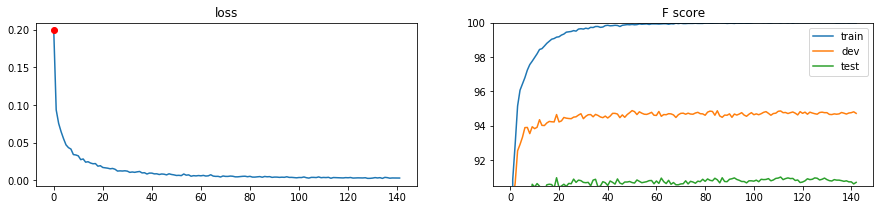

processed 46435 tokens with 5628 phrases; found: 5657 phrases; correct: 4975.
accuracy:  97.31%; precision:  87.94%; recall:  88.40%; FB1:  88.17
              LOC: precision:  89.61%; recall:  91.88%; FB1:  90.73  1704
             MISC: precision:  76.75%; recall:  79.08%; FB1:  77.90  714
              ORG: precision:  84.95%; recall:  85.21%; FB1:  85.08  1661
              PER: precision:  94.36%; recall:  92.08%; FB1:  93.21  1578
ID     NE  Total     O S-LOC B-PER E-PER S-ORGS-MISC B-ORG E-ORG S-PER I-ORG B-LOC E-LOCB-MISCE-MISCI-MISC I-PER I-LOC  Percent
 0      O  38323 37987    26     9     8    30    30    32    47    15    26     9    11    35    46    10     0     2    99.12
 1  S-LOC   1436    11  1332     3     1    40    19     6     2     4     2     4     2    10     0     0     0     0    92.76
 2  B-PER   1086     4     0  1063     0     0     1     8     0     0     0     3     0     5     0     0     2     0    97.88
 3  E-PER   1086     3     0     0  1064     0 

KeyboardInterrupt: 

In [14]:
opts.epochs = 150
data_num    = 20

start_time = datetime.now();print('training start -%s' % start_time);
every_losses, epoch_losses = [], []

## !! Train!!!
model.train(True)  # False시 validation, test - dropout, batchnorm 조절해줌
for epoch in range(0, opts.epochs):
    in_epoch_losses = []
    epoch_time = datetime.now();
    # train_data를 random으로 뽑아서 index 전달
#     for i, index in enumerate(np.random.permutation(len(train_data[:data_num]))):
    for i, index in enumerate(np.random.permutation(len(train_data))):
        count += 1  # batch = 1
        
        # data
        #{'str_words': ['Willem', 'II', 'Tilburg', '1', 'RKC', 'Waalwijk', '3'],
        # 'words': [2987, 2089, 2970, 17, 2925, 3369, 23],
        # 'chars': [[57, 5, 9, 9, 1, 14],
        #          [35, 35],
        #          [31, 5, 9, 21, 13, 7, 17],
        #          [23],
        #          [38, 60, 34],
        #          [57, 2, 2, 9, 20, 5, 62, 29],
        #          [39]],
        # 'caps': [2, 1, 2, 0, 1, 2, 0],
        # 'tags': [6, 9, 7, 0, 6, 7, 0]}        
        data = train_data[index]
        model.zero_grad()

        sentence_in = Variable(torch.LongTensor(data['words']))  # 'words': [2987, 2089, 2970, 17, 2925, 3369, 23]
        targets = torch.LongTensor(data['tags'])                 # tags'  : [6, 9, 7, 0, 6, 7, 0]}
        caps = Variable(torch.LongTensor(data['caps']))          # 'caps' : [2, 1, 2, 0, 1, 2, 0]
        chars2 = data['chars']  # 각 단어의 글자들을 묶음으로    # 'chars': [[57, 5, 9, 9, 1, 14], [35, 35], [31, 5, 9, 21, 13, 7, 17], ...]
        ############################################################################
        ## char 단위 임베딩
        # input  : chars2  - list, ex : [[54, 1], [8, 2, 5, 10], [2]]
        # output : matching_char(chars2_sorted와 실제 char2 매칭, ex, sorting 한 1번째는, 실제의 3번째줄이다 인 경우 -> {1:3, ....}), cnn 사용하는 경우 빈 dictionary
        #          chars2_length(list의 단어길이들, [2, 4, 1]), 
        #          chars2_mask(단어갯수, 가장 긴 단어의 글자길이) 를 구한다
        ############################################################################
        ######### 1. char lstm
        if opts.char_mode == 'LSTM':
            # 글자 길이 순으로 소팅
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            matching_char = {}

            # 0 [54, 1]
            # 1 [8, 2, 5, 10]

            # !! sorting 한 list가 sorting 안한 실제 list와 매칭
            # ex, sorting 한 1번째는, 실제의 3번째줄이다 인 경우 -> {1:3, ....}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in matching_char and not i in matching_char.values():
                        matching_char[j] = i
                        continue          
            # chars2_length, [2, 4, 1, 8, 4, ...]
            chars2_length = [len(c) for c in chars2_sorted]
            # char_maxl, 가장 긴 글자 크기 구하기
            char_maxl = max(chars2_length)
            # chars2_mask : (단어 갯수, 최대단어글자 길이)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        ############################################################################
        ######### 2. char cnn
        if opts.char_mode == 'CNN':
            matching_char = {}  # cnn을 사용하는 경우, 빈 dict 이다
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        ############################################################################
        # 변수들 gpu로 보내기
        if opts.use_gpu:
            sentence_in = sentence_in.cuda()
            targets     = targets.cuda()
            chars2_mask = chars2_mask.cuda()
            caps        = caps.cuda()
        ############################################################################
        ## 문장, 
        neg_log_likelihood = model.neg_log_likelihood(sentence = sentence_in, 
                                                      tags = targets, 
                                                      chars2 = chars2_mask, 
                                                      caps = caps, 
                                                      chars2_length = chars2_length, 
                                                      matching_char = matching_char)
        # 문장당 단어 갯수로 나눈 loss, 2단어로 된 문장은 loss/2
        loss = float(neg_log_likelihood.cpu().detach().numpy()) / len(data['words'])
        in_epoch_losses.append(loss)
#         loss += float(neg_log_likelihood.cpu().detach().numpy()) / len(data['words'])
#         in_epoch_losses.append(loss)
                
        neg_log_likelihood.backward()  # backprop
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # gradient clipping, 폭발 방지
        optimizer.step()  # 최적화
        ############################################################################
        ############################################################################


    epoch_losses.append(np.mean(in_epoch_losses))  # epoch의 평균 loss 계산
    ############################################################################
    ## epoch 단위, Evaluation
    ############################################################################
    model.train(False)  # evaluation을 위해, 훈련 X
    best_train_F, new_train_F, _,    _       = evaluating(model, test_train_data, best_train_F, epoch)
    best_test_F,  new_test_F,  _,    opts.best_idx= evaluating(model, test_data,       best_test_F, epoch)
    # validation의 결과가 best면 save를 True로, 모델이 저장되도록
    best_dev_F,   new_dev_F,   save, _       = evaluating(model, dev_data,        best_dev_F, epoch)
    
    if save: torch.save(model, opts.model_name)

    all_F.append([new_train_F, new_dev_F, new_test_F])
    ############################################################################
    ## visdom 출력
    ############################################################################
    ## 1. epoch F score 그래프 출력
    Fwin = 'F-score of {train, dev, test}_' + opts.name
    vis.line(X   = np.array([epoch]),
             Y   = np.array([all_F[epoch]]),
             win =Fwin, 
             opts={'title': Fwin, 'legend': ['train', 'dev', 'test']}, update='append')
    ## 2. epoch loss 그래프 출력
    losswin = 'loss_' + opts.name
    vis.line(X = np.array([epoch]),
             Y = np.array([epoch_losses[epoch]]),
             win=losswin, opts={'title': losswin, 'legend': ['loss']}, update='append')
    ## 3. epoch loss text 출력
    textwin = 'loss_text_' + opts.name
    text = '</p>'.join([str(n) +' - '+ str(round(l, 3)) for n, l in enumerate(epoch_losses)])
    vis.text(text, 
             win=textwin, opts={'title': textwin})
    ############################################################################
    
    model.train(True)  # 평가가 끝났으므로 다시 켜준다
    # 
    adjust_learning_rate(optimizer, lr=learning_rate/(1+0.05*count/len(train_data)))
    
    clear_output(wait = True)
    print('%d-시작/현재/epoch/소요:%s / %s / %s / %s' % (epoch, start_time, datetime.now(), (datetime.now()-epoch_time), (datetime.now() - start_time)))
    print('F train/valid/test : %.2f / %.2f / %.2f - %d'%(best_train_F, best_dev_F, best_test_F, opts.best_idx))
    
    fig = plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses)
    plt.plot(opts.best_idx, epoch_losses[opts.best_idx], 'ro')
    plt.title('loss')

    plt.subplot(1, 2, 2)
    plt.plot(all_F)
    plt.plot([opts.best_idx, opts.best_idx, opts.best_idx], all_F[opts.best_idx], 'ro')
    plt.title('F score')
    plt.legend(['train', 'dev', 'test'])
    plt.ylim([90.5, 100])
    plt.show()
    
    best_test_F, new_test_F,  _, _ = evaluating(model, test_data, best_test_F, epoch, display_confusion_matrix=True)

print('Done')

word_to_id:  400176
tag_to_id : 19개, {'O': 0, 'S-LOC': 1, 'B-PER': 2, 'E-PER': 3, 'S-ORG': 4, 'S-MISC': 5, 'B-ORG': 6, 'E-ORG': 7, 'S-PER': 8, 'I-ORG': 9, 'B-LOC': 10, 'E-LOC': 11, 'B-MISC': 12, 'E-MISC': 13, 'I-MISC': 14, 'I-PER': 15, 'I-LOC': 16, '<START>': 17, '<STOP>': 18}
111 91.01


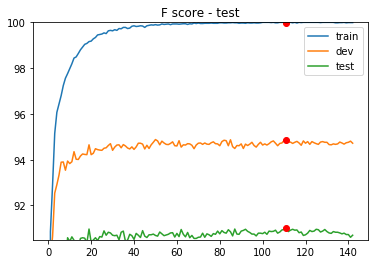

In [15]:
with open(opts.mapping_file, 'wb') as f:
    mappings = {
        'word_to_id'  : word_to_id,
        'tag_to_id'   : tag_to_id,
        'char_to_id'  : char_to_id,
        'parameters'  : opts,
        'word_embeds' : word_embeds,
        'epoch_losses': epoch_losses,
        'all_F'       : all_F
    }
    cPickle.dump(mappings, f)
print('word_to_id: ', len(word_to_id))
print('tag_to_id : %d개, %s' % (len(tag_to_id), tag_to_id))

max_temp=max_idx=0
for i in range(len(all_F)):
    if all_F[i][2] > max_temp:
        max_temp = all_F[i][2]
        max_idx = i
print(max_idx, max_temp)
plt.plot(all_F)
plt.plot([max_idx, max_idx, max_idx], all_F[max_idx], 'ro')
plt.title('F score - test')
plt.legend(['train', 'dev', 'test'])
plt.ylim([90.5,100])
plt.show()